# Reference: https://github.com/danieltan07/learning-to-reweight-examples/tree/master

In [1]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cuda'

In [3]:
Noise_0_dataframe = pd.read_csv("Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("Data/Assignment1/data_High_noise")

In [4]:
validation_dataframe=Noise_0_dataframe
dataframe=Noise_Low_dataframe
target_column="target_10_val"

In [5]:
class_index = list(dataframe[target_column].unique())
def encode(value, class_index = class_index):
    return class_index.index(value)

dataframe[target_column] = dataframe[target_column].apply(encode)
validation_dataframe[target_column] = validation_dataframe[target_column].apply(encode)

## Setting up Dataset & Dataloaders

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, noise, transform=None, target_transform=None,drop = None,target=None):
        self.dataframe = dataframe
        if drop != None:
            self.X = dataframe.drop(drop, axis=1).values
        else:
            self.X = dataframe.values
        self.y = dataframe[target].values
        self.transform = transform
        self.target_transform = target_transform
        self.noise = noise

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item, label = self.X[idx], self.y[idx]
        return item, label

    def get_noise(self):
        return self.noise

In [7]:
dataset = CustomDataset(dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val","data_type"],target=target_column)
Noise_train, Noise_test = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

In [8]:
Noise_train_loader = DataLoader(Noise_train, batch_size=64, shuffle=True)
Noise_test_loader = DataLoader(Noise_test, batch_size=64, shuffle=True)

Setting Up Validation Dataset

In [9]:
val_dataset=CustomDataset(validation_dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val"],target=target_column)
val_loader=DataLoader(val_dataset, batch_size=64, shuffle=True)

# Setting UP MLP

In [10]:
import torch.nn as nn
import torch.nn.init as init

In [11]:
def SampleMiniBatch(loader,count):
    count=count%len(loader)
    temp=0
    for val_input,val_labels in loader:
        if temp==count:
            return val_input,val_labels
    return None

In [12]:
from torch.autograd import Variable 

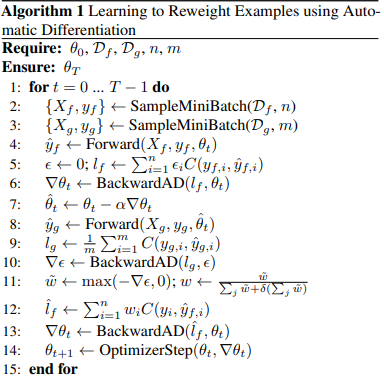

In [53]:
def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)


class MetaModule(nn.Module):
    # adopted from: Adrien Ecoffet https://github.com/AdrienLE
    def params(self):
       for name, param in self.named_params(self):
            yield param
    
    def named_leaves(self):
        return []
    
    def named_submodules(self):
        return []
    
    def named_params(self, curr_module=None, memo=None, prefix=''):       
        if memo is None:
            memo = set()

        if hasattr(curr_module, 'named_leaves'):
            for name, p in curr_module.named_leaves():
                if p is not None and p not in memo:
                    memo.add(p)
                    yield prefix + ('.' if prefix else '') + name, p
        else:
            for name, p in curr_module._parameters.items():
                if p is not None and p not in memo:
                    memo.add(p)
                    yield prefix + ('.' if prefix else '') + name, p
                    
        for mname, module in curr_module.named_children():
            submodule_prefix = prefix + ('.' if prefix else '') + mname
            for name, p in self.named_params(module, memo, submodule_prefix):
                yield name, p
    
    def update_params(self, lr_inner, first_order=False, source_params=None, detach=False):
        if source_params is not None:
            for tgt, src in zip(self.named_params(self), source_params):
                name_t, param_t = tgt
                # name_s, param_s = src
                # grad = param_s.grad
                # name_s, param_s = src
                grad = src
                if first_order:
                    grad = to_var(grad.detach().data)
                tmp = param_t - lr_inner * grad
                self.set_param(self, name_t, tmp)
        else:

            for name, param in self.named_params(self):
                if not detach:
                    grad = param.grad
                    if first_order:
                        grad = to_var(grad.detach().data)
                    tmp = param - lr_inner * grad
                    self.set_param(self, name, tmp)
                else:
                    param = param.detach_()
                    self.set_param(self, name, param)

    def set_param(self,curr_mod, name, param):
        print(curr_mod, name, param)
        if '.' in name:
            n = name.split('.')
            module_name = n[0]
            rest = '.'.join(n[1:])
            for name, mod in curr_mod.named_children():
                if module_name == name:
                    self.set_param(mod, rest, param)
                    break
        else:
            setattr(curr_mod, name, param)
            
    def detach_params(self):
        for name, param in self.named_params(self):
            self.set_param(self, name, param.detach())   
                
    def copy(self, other, same_var=False):
        for name, param in other.named_params():
            if not same_var:
                param = to_var(param.data.clone(), requires_grad=True)
            self.set_param(name, param)

In [54]:
class Meta_MLP(MetaModule):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Meta_MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax=nn.Softmax()
        self.relu = nn.ReLU()
        self.sigm =nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        y_hat = self.fc2(x)
        y_hat = self.softmax(y_hat)
        # h = self.att_layer(x)
        # h=  self.sigm(h)
        return y_hat

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


def train_meta_model(model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs=10, verbose=True, lr=0.001):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        count = 0
        for inputs, labels in train_loader:
            # line 2
            inputs, labels = inputs.to(device).to(
                torch.float32), labels.to(device).to(torch.long)
            inputs = Variable(inputs, requires_grad=False)
            labels = Variable(labels, requires_grad=False)
            # duplicate network for training
            model_duplicate = Meta_MLP(24, 128, 5)
            model_duplicate.load_state_dict(model.state_dict())
            model_duplicate.to(device)

            # line 4
            y_f_hat = model_duplicate(inputs)
            # line 5
            cost = criterion(y_f_hat, labels)
            cost = cost.to(device)
            eps = Variable(torch.zeros(cost.size()), requires_grad=True)
            eps = eps.to(device)
            l_f = torch.sum(cost*eps).to(device)

            # line 6
            model_duplicate.zero_grad()
            grads = torch.autograd.grad(
                l_f, (model_duplicate.params()), create_graph=True)

            # Jaadoo (Line #7)
            model_duplicate.update_params(lr, source_params=grads)

            val_inputs, val_labels = SampleMiniBatch(val_loader, count)
            val_inputs, val_labels = val_inputs.to(device).to(
                torch.float32), val_labels.to(device).to(torch.long)
            val_inputs = Variable(val_inputs, requires_grad=False)
            val_labels = Variable(val_labels, requires_grad=False)
            count += 1
            # line 8
            y_g_hat = model_duplicate(val_inputs)

            # line 9
            l_g = criterion(y_g_hat, val_labels)
            l_g = l_g.mean()
            # print(l_g)

            # line 10
            grad_eps = torch.autograd.grad(l_g, eps)[0]
            print(grad_eps)
            # print(grad_eps)

            # line 11
            w_tilde = torch.clamp(-grad_eps, min=0)
            norm_c = torch.sum(w_tilde)

            if norm_c != 0:
                w = w_tilde / norm_c
            else:
                w = w_tilde

            # line 12
            y_f_hat = model(inputs)
            cost = criterion(y_f_hat, labels)
            l_f = torch.sum(cost * w)

            # line 13
            optimizer.zero_grad()
            l_f.backward()
            optimizer.step()
            running_train_loss += l_f.item()
            _, predicted = torch.max(y_f_hat[0], 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device).to(
                    torch.float32), labels.to(device).to(torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs[0], 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

In [56]:
Model = Meta_MLP(24,128,5)
Model = Model.to(device)

In [57]:
optimizer = optim.Adam(Model.parameters(), lr=0.001, weight_decay=0.001)

In [58]:
train_meta_model(Model,torch.nn.CrossEntropyLoss(reduction="none"),optimizer,Noise_train_loader,val_loader,Noise_test_loader,num_epochs=5)

Meta_MLP(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (softmax): Softmax(dim=None)
  (relu): ReLU()
  (sigm): Sigmoid()
) fc1.weight tensor([[-0.0060,  0.0065, -0.1567,  ...,  0.0372, -0.0479, -0.1575],
        [ 0.1223, -0.0893, -0.1514,  ..., -0.0945, -0.0469, -0.0743],
        [ 0.0774,  0.0229, -0.0957,  ...,  0.1104,  0.0915,  0.0243],
        ...,
        [ 0.1945,  0.1797, -0.0132,  ...,  0.1447, -0.1464,  0.0517],
        [ 0.1015, -0.1541,  0.0728,  ...,  0.1505,  0.1527, -0.1989],
        [-0.0536,  0.0927, -0.0383,  ...,  0.0839,  0.1011, -0.1972]],
       device='cuda:0', grad_fn=<SubBackward0>)
Linear(in_features=24, out_features=128, bias=True) weight tensor([[-0.0060,  0.0065, -0.1567,  ...,  0.0372, -0.0479, -0.1575],
        [ 0.1223, -0.0893, -0.1514,  ..., -0.0945, -0.0469, -0.0743],
        [ 0.0774,  0.0229, -0.0957,  ...,  0.1104,  0.0915,  0.0243],
        ...,
        [ 0.1945,  0.179

TypeError: cannot assign 'torch.cuda.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

In [ ]:
len(dataset)

312000